阅读XGBoost算法的推导过程  在上周作业的基础上，完成下述工作：2.使用格搜索完成随机森林的参数优化，并比较优化前后的准确度；3.使用Adboost和XGBoost算法完成同样的分类问题，比较各种算法的正确度、F1值，并在同一张图画出它们的ROC曲线

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 数据加载

In [2]:
df = pd.read_csv('Churn-Modelling-new.csv')
print(df.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited        EB  
0        101348.88       1  0.000000  
1        112542.58       0  0.744677  
2        113931.57       1  1.401375  
3 

In [3]:
df.drop(columns=['RowNumber','CustomerId','Surname','EB'], inplace=True)
df['CreditScore'] = pd.cut(df['CreditScore'], bins=10)  # 将数据分成4个等宽的区间
df['Age'] = pd.cut(df['Age'], bins=10) 
df['Balance'] = pd.cut(df['Balance'], bins=10) 
df['EstimatedSalary'] = pd.cut(df['EstimatedSalary'], bins=10) 

label_encoder = LabelEncoder()
df['CreditScore'] = label_encoder.fit_transform(df['CreditScore'])
df['Age'] = label_encoder.fit_transform(df['Age'])
df['Balance'] = label_encoder.fit_transform(df['Balance'])
df['EstimatedSalary'] = label_encoder.fit_transform(df['EstimatedSalary'])

df['Geography'] = label_encoder.fit_transform(df['Geography'])
df['Gender'] = label_encoder.fit_transform(df['Gender'])

# 数据集划分

In [4]:
X = df.drop(columns=['Exited'])
y = df['Exited']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 模型训练

In [17]:
# 定义XGBoost分类器
xgb_classifier = XGBClassifier()

# 定义超参数网格
param_grid = {
    'n_estimators': [10, 20, 30],  # 估计器的数量
    'max_depth': [4, 5, 6],         # 树的最大深度
    'learning_rate': [0.1, 0.01],   # 学习率
}

# 创建GridSearchCV对象
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=10, scoring='roc_auc')

# 在训练数据上拟合GridSearch
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
best_xgb = grid_search.best_estimator_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 30}


In [19]:
# 创建AdaBoost分类器
base_classifier = DecisionTreeClassifier(max_depth=1)
adaboost = AdaBoostClassifier(base_classifier)

# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [5, 10, 20],
    'learning_rate': [0.1, 0.5, 1.0],
}

# 使用GridSearchCV进行参数调优
grid_search = GridSearchCV(adaboost, param_grid, scoring='roc_auc', cv=10)
grid_search.fit(X_train, y_train)

# 打印最佳参数
print("最佳参数组合:", grid_search.best_params_)
best_adaboost = grid_search.best_estimator_

最佳参数组合: {'learning_rate': 1.0, 'n_estimators': 20}


In [23]:
# 定义超参数网格
param_grid = {
    'n_estimators': [5, 10, 20],
    'max_depth': [10, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 创建Random Forest分类器
rf_classifier = RandomForestClassifier(random_state=42)
# 使用GridSearchCV来寻找最佳参数组合
grid_search = GridSearchCV(rf_classifier, param_grid, cv=10, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# 打印最佳参数
print("最佳参数组合:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

最佳参数组合: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 20}


# 评价

In [52]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # 计算ROC曲线和AUC
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # 输出结果
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'AUC: {roc_auc:.2f}')
    
    return fpr,tpr
    

调参前random forest的AUC为0.82

XGBoost
Precision: 0.81
Recall: 0.44
F1 Score: 0.57
AUC: 0.86


AdaBoost
Precision: 0.72
Recall: 0.48
F1 Score: 0.57
AUC: 0.85


Random Forest
Precision: 0.80
Recall: 0.43
F1 Score: 0.56
AUC: 0.85




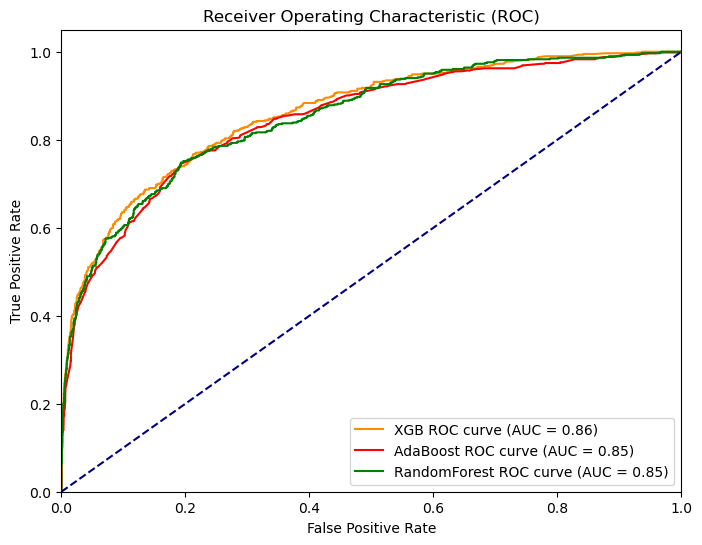

In [53]:
# 绘制ROC曲线
plt.figure(figsize=(8, 6))

print("XGBoost")
fpr1, tpr1 = evaluate(best_xgb, X_test, y_test)
roc_auc_xgb = auc(fpr1, tpr1)
print('\n')

print("AdaBoost")
fpr2, tpr2 = evaluate(best_adaboost, X_test, y_test)
roc_auc_adaboost = auc(fpr2, tpr2)
print('\n')

print("Random Forest")
fpr3, tpr3 = evaluate(best_rf, X_test, y_test)
roc_auc_rf = auc(fpr3, tpr3)
print('\n')



plt.plot(fpr1, tpr1, color='darkorange', label=f'XGB ROC curve (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr2, tpr2, color='red', label=f'AdaBoost ROC curve (AUC = {roc_auc_adaboost:.2f})')
plt.plot(fpr3, tpr3, color='green', label=f'RandomForest ROC curve (AUC = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()